##Loader

In [ ]:
!pip install latextable
!pip install names
!pip install num2words

  Created wheel for latextable: filename=latextable-0.2.1-py3-none-any.whl size=6243 sha256=b21e95b53e52cdc1f2ab8675434c66508cd7bd75a3ad8f27c701ed9db377e8c2
  Stored in directory: /root/.cache/pip/wheels/51/dc/99/540a81a40d112def87a9a200851a58d1ed6a866cfab4e93e56
Successfully built latextable
     |████████████████████████████████| 789 kB 13.2 MB/s 
  Created wheel for names: filename=names-0.3.0-py3-none-any.whl size=803699 sha256=940fb87aff867ce9fef22abf9dc75aa7d1a72a19f817e6ab16010e5e3744fd1c
  Stored in directory: /root/.cache/pip/wheels/05/ea/68/92f6b0669e478af9b7c3c524520d03050089e034edcc775c2b
Successfully built names
     |████████████████████████████████| 101 kB 5.6 MB/s 


In [ ]:
import random
from random import randint, choice, sample

import latextable
from texttable import Texttable

from sympy import *

variables = 'a b c d m n p q r s t w x y'
variables = symbols(variables, real=True)
variables += (Symbol('z'),)
a,b,c,d,m,n,p,q,r,s,t,w,x,y,z = variables

###Functions and sequences

In [ ]:
class LinFunc():
    """
    Represent a linear function.

    Attributes
    ----------
        slope : number (int, float, or Rational)
        intercept : number
        variable : sympy symbol, default=x
        label : str, default='f'
        expr : sympy expression
        domain : sympy set, default=S.Reals
        precision : int, default=2
    """

    def __init__(self, slope, pt, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct linear function object from slope and y-intercept.

        Parameters
        ----------
            slope : number (int, float, or Rational)
            pt : number or list
            variable : sympy symbol, default=x
            label : str, default='f'
            domain : sympy set, default=S.Reals
            precision : int, default=2
        """
        
        self.slope, pt = sympify([slope, pt])
        
        self.intercept = pt[1] - pt[0]*self.slope if type(pt)==list else pt
        self.expr = self.slope*variable + self.intercept

        self.variable = variable
        self.label = label
        self.domain = domain
        self.precision = precision
    
    def __str__(self):
        """Return LaTeX formatted slope-intercept form."""
        
        if self.slope in [0,1]:
            slopeInt = ''
        elif self.slope == -1:
            slopeInt = '-'
        else:
            slopeInt = latexify(self.slope, self.precision)
        slopeInt += latex(self.variable) if self.slope!=0 else '' 
        
        intercept = latexify(self.intercept, self.precision)
        if self.intercept>0 and self.slope!=0:
            slopeInt += ' + '
        if self.intercept!=0 or self.slope==0:
            slopeInt += intercept
            
        return slopeInt
    
    @classmethod
    def fromPts(cls, pt1, pt2, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct linear function object from two ordered pairs.

        Parameters
        ----------
            pt1, pt2 : list or tuple
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        pt1, pt2 = sympify([pt1, pt2])
        
        slope = (pt2[1] - pt1[1])/(pt2[0] - pt1[0])
        
        if pt1[0]==0:
            return cls(slope, pt1[1], variable, label, domain, precision)
        elif pt2[0]==0:
            return cls(slope, pt2[1], variable, label, domain, precision)
        else:
            return cls(slope, pt1, variable, label, domain, precision)

    def subs(self, input):
        """Return evaluation of function at input."""

        return self.expr.subs(self.variable, sympify(input))

    def subSet(self, preimage):
        """Return image of set."""

        return ImageSet(Lambda(self.variable, self.expr), preimage).intersect(S.Reals)

    def getRange(self):
        """Return range of function."""

        return self.subSet(self.domain)
        
    def solve(self, output):
        if self.slope == 0:
            return self.domain if output==self.intercept else None
        else:
            return (sympify(output)-self.intercept)/self.slope

    def getSlopeInt(self, notation='func'):
        """Return LaTeX formatted slope-intercept form."""

        if notation == 'func':
            return f'{self.label}({self.variable}) = ' + str(self)
        else:
            return notation + '=' + str(self)

    def getPtSlope(self, pt=1, notation='func'):
        """
        Return LaTeX formatted point-slope form.
        
        Parameters
        ---------
            pt : number or list/tuple
                Independent variable value or ordered pair.
            notation : string, default='func'
                LHS of equality, default returns function notation.
        """

        pt = sympify(pt)
        if type(pt)!=list:
            pt = [pt] + [self.subs(pt)]
        
        ptTex = latexify(pt, self.precision)
        
        if self.slope in [0,1]:
            ptSlope = ''
        elif self.slope == -1:
            ptSlope = '-'
        else:
            ptSlope = latexify(self.slope, self.precision)
            
        if self.slope!=0:
            ptSlope += r'\left(' + latex(self.variable)
            ptSlope += '+' + ptTex[0][1:] if pt[0]<0 else '-' + ptTex[0]
            ptSlope += r'\right)'
        
        if pt[1]>0 and self.slope!=0:
            ptSlope += ' + '
        if pt[1]!=0 or self.slope==0:
            ptSlope += ptTex[1]
        
        if notation == 'func':
            return fr'{self.label}({self.variable}) = ' + ptSlope
        else:
            return notation + '=' + ptSlope
            
    def getStdForm(self, notation='y', mult=1):
        if self.slope == 0:
            mult = nsimplify(self.intercept).q
        elif self.intercept == 0:
            mult = nsimplify(self.slope).q
        else:
            mult *= abs(lcm(nsimplify(self.slope).q, nsimplify(self.intercept).q))
        mult = -mult if self.slope<=0 else mult
        
        stdForm = latex(nsimplify(mult*self.slope*self.variable - mult)) + notation
        stdForm += '=' + latex(nsimplify(-mult*self.intercept))
        
        return stdForm
        
    def getTable(self, nums, vals=True, vertical=True, labels=None):
        """
        Return LaTeX formatted table at given positions with or without blanks.
        
        Parameters
        ----------
            nums : list of ints
            vals : bool or list of bools or nonempty/empty strings ('')
            vertical : bool, default=True
            labels : list, default=None
                Defaults are independent variable and function notation.
        """
        
        vals = len(nums)*[vals] if type(vals)==bool else vals
        images = [signify(latexify(self.subs(jj), self.precision)) for jj in nums]
        images = [jj if vals[count] else r'\phantom{' + jj + r'}' for count,jj in enumerate(images)]
        
        nums = sympify(nums)
        nums = [signify(latexify(jj, self.precision)) for jj in nums]
        
        if labels == None:
            labels = [signify(str(self.variable)), fr'${self.label}({self.variable})$']
        if vertical:
            header = labels
            rows = list(zip(nums,images))
        else:
            header = [labels[0]] + list(nums)
            rows = [[labels[1]] + images]
        
        return tableGenerator(header, rows)

In [ ]:
class ExpFunc():
    """
    Represent an exponential function.

    Attributes
    ----------
        base : number (int, float, or Rational)
        intercept : number
        shift : number
        variable : sympy symbol, default=x
        label : str, default='f'
        expr : sympy expression
        domain : sympy set, default=S.Reals
        precision : int, default=2
    """

    def __init__(self, base, pt, shift=0, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct exponential function object from base, point/y-int, and vertical shift.

        Parameters
        ----------
            base : number (int, float, or Rational)
            intercept : number
            shift : number
            variable : sympy symbol, default=x
            label : str, default='f'
            domain : sympy set, default=S.Reals
            precision : int, default=2
        """

        self.base, pt, self.shift = sympify([base, pt, shift])

        self.lead = (pt[1]-self.shift)/Pow(self.base,pt[0]) if type(pt)==list else pt-self.shift
        self.expr = self.lead*(self.base**variable) + self.shift

        self.intercept = self.lead + self.shift
        
        self.variable = variable
        self.label = label
        self.domain = domain
        self.precision = precision
    
    def __str__(self):
        """Return LaTeX formatted standard form."""

        if self.lead == 1:
            string = ''
        elif self.lead == -1:
            string = '-'
        else:
            string = latexify(self.lead, self.precision)
            if type(self.base)==Integer and self.base>0:
                string += r' \cdot '
            
        if type(self.base)==Float or abs(self.base.q)>999:
            base = latexify(self.base, self.precision)
            string += fr'({base})^{self.variable}'
        else:            
            string += latex(self.base**self.variable)

        if self.shift != 0:
            string += ('+' + latexify(self.shift)) if self.shift>0 else latexify(self.shift)
            
        return string
    
    @classmethod
    def fromPts(cls, pt1, pt2, shift=0, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct exponential function object from two ordered pairs.

        Parameters
        ----------
            pt1, pt2 : list or tuple
            variable : sympy symbol, default=x
            label : str, default='f'
        """
        
        pt1, pt2, shift = sympify([pt1, pt2, shift])
        
        base = Pow((pt2[1]-shift)/(pt1[1]-shift), 1/(pt2[0]-pt1[0]))
        
        if pt1[0]==0:
            return cls(base, pt1[1], shift, variable, label, domain, precision)
        elif pt2[0]==0:
            return cls(base, pt2[1], shift, variable, label, domain, precision)
        else:
            return cls(base, pt1, shift, variable, label, domain, precision)

    def subs(self, input):
        """Return evaluation of function at input."""

        return self.expr.subs(self.variable, sympify(input))

    def subSet(self, preimage):
        """Return image of set."""

        return ImageSet(Lambda(self.variable, self.expr), preimage).intersect(S.Reals)

    def getRange(self):
        """Return range of function."""

        return self.subSet(self.domain)
        
    def solve(self, output):
        """Return preimage of given output."""
        
        soln = log((sympify(output)-self.shift)/self.lead, self.base)

        return soln if soln in S.Reals else None
    
    def getStdForm(self, notation='func'):
        """Return LaTeX formatted standard form."""

        if notation == 'func':
            return fr'{self.label}({self.variable}) = ' + str(self)
        else:
            return notation + '=' + str(self)
    
    def getBaseInt(self, notation='func'):
        """Return LaTeX formatted base-intercept form."""

        return self.getStdForm(notation)

    def getPtBase(self, pt=1, notation='func'):
        """
        Return LaTeX formatted point-base form.
        
        Parameter
        ---------
            pt : number or list/tuple
                Independent variable value or ordered pair.
            notation : string, default='func'
                LHS of equality, default returns function notation.
        """

        pt = sympify(pt)
        pt, lead = [pt, self.subs(pt)-self.shift] if type(pt) not in [list,tuple] else [pt[0], pt[1]-self.shift]
         
        if lead == 1:
            ptBase = ''
        elif lead == -1:
            ptBase = '-'
        else:
            ptBase = latexify(lead, self.precision)
            if type(self.base)==Integer and self.base>0:
                ptBase += r' \cdot '
            
        if type(self.base)==Float or abs(self.base.q)>999:
            base = latexify(self.base, self.precision)
            ptBase += fr'({base})^' + r'{' + latex(self.variable-pt) + r'}'
        else:
            ptBase += latex(self.base**(self.variable - pt))
        
        if self.shift != 0:
            ptBase += ('+' + latexify(self.shift)) if self.shift>0 else latexify(self.shift)
            
        if notation == 'func':
            return fr'{self.label}({self.variable}) = ' + ptBase
        else:
            return notation + '=' + ptBase
        
    def getTable(self, nums, vals=True, vertical=True, labels=None):
        """
        Return LaTeX formatted table at given positions with or without blanks.
        
        Parameters
        ----------
            nums : list of ints
            vals : bool or list of bools or nonempty/empty strings ('')
            vertical : bool, default=True
            labels : list, default=None
                Defaults are independent variable and function notation.
        """
        
        vals = len(nums)*[vals] if type(vals)==bool else vals
        images = [signify(latexify(self.subs(jj), self.precision)) for jj in nums]
        images = [jj if vals[count] else r'\phantom{' + jj + r'}' for count,jj in enumerate(images)]
        
        nums = sympify(nums)
        nums = [signify(latexify(jj, self.precision)) for jj in nums]
        
        if labels == None:
            labels = [signify(str(self.variable)), fr'${self.label}({self.variable})$']
        if vertical:
            header = labels
            rows = list(zip(nums,images))
        else:
            header = [labels[0]] + list(nums)
            rows = [[labels[1]] + images]
        
        return tableGenerator(header, rows)

In [ ]:
class QuadFunc():
    """
    Represent a quadratic function.

    Attributes
    ----------
        aa : number (int, float, or Rational)
        bb : number
        cc : number
        
        variable : sympy symbol, default=x
        label : str, default='f'
        expr : sympy expression
        domain : sympy set, default=S.Reals
        precision : int, default=2
    """

    def __init__(self, aa, bb, cc, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct quadratic function object from coefficients.

        Parameters
        ----------
            aa : number (int, float, or Rational)
            bb : number
            cc : number
            variable : sympy symbol, default=x
            label : str, default='f'
            domain : sympy set, default=S.Reals
            precision : int, default=2
        """
        
        self.aa, self.bb, self.cc = sympify([aa, bb, cc])
        
        self.expr = self.aa*variable**2 + self.bb*variable + self.cc

        self.variable = variable
        self.label = label
        self.domain = domain
        self.precision = precision
    
    def __str__(self):
        """Return LaTeX formatted standard form."""
        
        if self.aa in [0,1]:
            stdForm = ''
        elif self.aa == -1:
            stdForm = '-'
        else:
            stdForm = latexify(self.aa, self.precision)
        stdForm += latex(self.variable**2) if self.aa!=0 else '' 
        
        bb = latexify(self.bb, self.precision)
        if self.bb>0 and self.aa!=0:
            stdForm += ' + '
        if self.bb == -1:
            stdForm += ' - '
        elif self.bb not in [0,1]:
            stdForm += bb
        stdForm += latex(self.variable) if self.bb!=0 else ''
            
        cc = latexify(self.cc, self.precision)
        if self.cc>0 and (self.aa!=0 or self.bb!=0):
            stdForm += ' + '
        if self.cc!=0 or (self.aa==0 and self.bb==0):
            stdForm += cc
            
        return stdForm
    
    @classmethod
    def fromVertex(cls, aa, vertex, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct quadratic function object from stretch factor (a) and vertex.

        Parameters
        ----------
            aa : number
            vertex : list or tuple
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        aa, hh, kk = sympify([aa, *vertex])
        
        return cls(aa, -2*aa*hh, a*hh**2+kk, variable, label, domain, precision)
    
    @classmethod
    def fromRoots(cls, aa, root1, root2, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct quadratic function object from stretch factor (a) and roots.

        Parameters
        ----------
            aa : number
            root1, root2 : numbers
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        aa, root1, root2 = sympify([aa, root1, root2])
        
        return cls(aa, -aa*(root1+root2), a*root1*root2, variable, label, domain, precision)
    
    @classmethod
    def from2Pts(cls, aa, pt1, pt2, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct quadratic function object from stretch factor (a) and 2 points.

        Parameters
        ----------
            aa : number
            pt1, pt2 : lists or tuples
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        aa, pt1, pt2 = sympify([aa, pt1, pt2])

        expr = aa*x**2 + b*x + c
        coeffs = solve([expr.subs(x,pt1[0])-pt1[1], expr.subs(x,pt2[0])-pt2[1]])
        
        return cls(aa, coeffs[b], coeffs[c], variable, label, domain, precision)
    
    @classmethod
    def from3Pts(cls, pt1, pt2, pt3, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct quadratic function object from 3 points.

        Parameters
        ----------
            pt1, pt2, pt3 : lists or tuples
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        pt1, pt2, pt3 = sympify([pt1, pt2, pt3])

        expr = a*x**2 + b*x + c
        coeffs = solve([expr.subs(x,pt1[0])-pt1[1], expr.subs(x,pt2[0])-pt2[1], expr.subs(x,pt3[0])-pt3[1]])
        
        return cls(coeffs[a], coeffs[b], coeffs[c], variable, label, domain, precision)

    def subs(self, input):
        """Return evaluation of function at input."""

        return self.expr.subs(self.variable, sympify(input))

    def subSet(self, preimage):
        """Return image of set."""

        return ImageSet(Lambda(self.variable, self.expr), preimage).intersect(S.Reals)

    def getRange(self):
        """Return range of function."""

        return self.subSet(self.domain)
        
    def solve(self, output):
        return solve(self.expr.subs(self.variable,z)-output)

    def getVertex(self):
        hh = -Rational(self.bb,2*self.aa)
        return [hh, self.subs(hh)]

    def getRoots(self):
        return self.solve(0)

    def getStdForm(self, notation='func'):
        """Return LaTeX formatted standard form."""

        if notation == 'func':
            return f'{self.label}({self.variable}) = ' + str(self)
        else:
            return notation + '=' + str(self)

    # def getPtSlope(self, pt=1, notation='func'):
        # """
        # Return LaTeX formatted point-slope form.
        
        # Parameter
        # ---------
            # pt : number or list/tuple
                # Independent variable value or ordered pair.
        # """

        # pt = sympify(pt)
        # if type(pt)!=list:
            # pt = [pt] + [self.subs(pt)]
        
        # ptTex = latexify(pt, self.precision)
        
        # if self.slope in [0,1]:
            # ptSlope = ''
        # elif self.slope == -1:
            # ptSlope = '-'
        # else:
            # ptSlope = latexify(self.slope, self.precision)
            
        # if self.slope!=0:
            # ptSlope += r'\left(' + latex(self.variable)
            # ptSlope += '+' + ptTex[0][1:] if pt[0]<0 else '-' + ptTex[0]
            # ptSlope += r'\right)'
        
        # if pt[1]>0 and self.slope!=0:
            # ptSlope += ' + '
        # if pt[1]!=0 or self.slope==0:
            # ptSlope += ptTex[1]
        
        # if notation == 'func':
            # return fr'{self.label}({self.variable}) = ' + ptSlope
        # else:
            # return notation + '=' + ptSlope
        
    def getTable(self, nums, vals=True, vertical=True, labels=None):
        """
        Return LaTeX formatted table at given positions with or without blanks.
        
        Parameters
        ----------
            nums : list of ints
            vals : bool or list of bools or nonempty/empty strings ('')
        """
        
        vals = len(nums)*[vals] if type(vals)==bool else vals
        images = [signify(latexify(self.subs(jj), self.precision)) for jj in nums]
        images = [jj if vals[count] else r'\phantom{' + jj + r'}' for count,jj in enumerate(images)]
        
        nums = sympify(nums)
        nums = [signify(latexify(jj, self.precision)) for jj in nums]
        
        if labels == None:
            labels = [signify(str(self.variable)), fr'${self.label}({self.variable})$']
        if vertical:
            header = labels
            rows = list(zip(nums,images))
        else:
            header = [labels[0]] + list(nums)
            rows = [[labels[1]] + images]
        
        return tableGenerator(header, rows)

In [ ]:
class PWFunc():
    """
    Represent a piecewise function.

    Attributes
    ----------
        variable : sympy symbol, default=x
        label : str, default='f'
        expr : sympy expression
        domain : sympy set
    """

    def __init__(self, *pairs, variable=x, label='f'):
        """
        Construct piecewise function object from expr-interval pairs.

        Parameters
        ----------
            pairs : array of expr-interval pairs
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        self.variable = variable
        self.label = label
        
        exprs, intervals = zip(*pairs)
        intervals = list(map(makeInterval, intervals))
        self.pairs = list(zip(exprs, intervals))
        
        pieces = [[row[0], Contains(variable, row[1])] for row in self.pairs]
        self.expr = Piecewise(*pieces)
        
        self.domain = Union(*intervals)
    
    def __str__(self):
        """Return LaTeX."""
        # TODO: relational instead of intervals

        return fr'{self.label}({self.variable}) = ' + latex(self.expr)

    def subs(self, input):
        """Return evaluation of function at input."""

        return nsimplify(self.expr.subs(self.variable, input))

    def subSet(self, preimage):
        """Return image of set."""
        
        image = S.EmptySet
        for expr, interval in self.pairs:
            image = Union(image, ImageSet(Lambda(self.variable,expr),interval.intersect(preimage)))

        return image.intersect(S.Reals)

    def getRange(self):
        """Return range of function."""

        image = S.EmptySet
        for expr, interval in self.pairs:
            image = Union(image, ImageSet(Lambda(self.variable,expr),interval))

        return image.intersect(S.Reals)
        
    def solve(self, output):
        """Return preimage of given output."""
        solns = []
        
        for expr, interval in self.pairs:
            strings = solve(expr-output, self.variable)
            for ans in strings:
                if ans in interval:
                    solns.append(ans)
        
        return list(set(solns))
    
    def getLatex(self):
        """Return LaTeX."""

        return str(self)

    def getFeats(self, feats='all'):           # TODO: INC/DEC
        feats = ['domain','range','intercepts','extrema','change'] if feats=='all' else feats

        features = dict()
        if 'domain' in feats:
            features['domain'] = self.domain
        if 'range' in feats:
            features['range'] = self.getRange()
        if 'intercepts' in feats:
            features['yint'] = self.subs(0) if 0 in self.domain else None
            features['xints'] = self.solve(0)
        if 'extrema' in feats:
            rangeset = self.getRange()
            features['mins'] = [self.solve(rangeset.inf), rangeset.inf]
            features['maxes'] = [self.solve(rangeset.sup), rangeset.sup]
        if 'change' in feats:
            features.update({'inc': EmptySet, 'dec': EmptySet, 'const': EmptySet})
            for expr, interval in self.pairs:
                deriv = diff(expr,self.variable).subs(self.variable,z)
                if deriv.is_constant():
                    if deriv > 0:
                        features['inc'] = Union(features['inc'], interval)
                    elif deriv < 0:
                        features['dec'] = Union(features['dec'], interval)
                    else:
                        features['const'] = Union(features['const'], interval)
                else:
                    inc = Intersection(solve(deriv>0,self.variable).as_set(), interval)
                    features['inc'] = Union(features['inc'], inc)
                    features['dec'] = Union(features['dec'], interval-inc.closure)

        return features

    def printFeats(self, feats='all'):
        feats = ['domain','range','intercepts','extrema','change'] if feats=='all' else feats
        
        features, string = self.getFeats(feats), ''
        if 'domain' in feats:
            string += 'Domain: ' + signify(latexify(features['domain'])) + r' \newline '
        if 'range' in feats:
            string += 'Range: ' + signify(latexify(features['range'])) + r' \newline '

        if 'intercepts' in feats:
            string += '$y$-intercept: '
            if features['yint']==None:
                string += r'None \newline '
            else:
                string += signify(f'(0, {latexify(features["yint"])})') + r' \newline '

            string += '$x$-intercept(s): '
            if len(features['xints']) == 0:
                string += r'None \newline '
            else:
                xints = [jj if type(jj) in [int,Integer] else float(jj) for jj in features['xints']]
                string += signify(', '.join([f'({latexify(jj)}, 0)' for jj in xints])) + r' \newline '

        if 'extrema' in feats:
            features['mins'][1] = features['mins'][1] if type(features['mins'][1]) in [int,Integer] else float(features['mins'][1])
            string += 'Minimum: '
            if len(features['mins'][0]) > 0:
                mins = [jj if type(jj) in [int,Integer] else float(jj) for jj in features['mins'][0]]
                string += signify(latexify(features['mins'][1])) + ', occurs at $x=' + ', '.join([latexify(jj) for jj in mins]) + r'$ \newline '
            else:
                string += 'None (approaches ' + signify(latexify(features['mins'][1])) + r') \newline '
                
            features['maxes'][1] = features['maxes'][1] if type(features['maxes'][1]) in [int,Integer] else float(features['maxes'][1])
            string += 'Maximum: '
            if len(features['maxes'][0]) > 0:
                maxes = [jj if type(jj) in [int,Integer] else float(jj) for jj in features['maxes'][0]]
                string += signify(latexify(features['maxes'][1])) + ', occurs at $x=' + ', '.join([latexify(jj) for jj in maxes]) + r'$ \newline '
            else:
                string += 'None (approaches ' + signify(latexify(features['maxes'][1])) + r') \newline '

        if 'change' in feats:
            string += 'Increasing: ' + (signify(latexify(features['inc'])) if features['inc']!=EmptySet else 'None') + r'\newline '
            string += 'Decreasing: ' + (signify(latexify(features['dec'])) if features['dec']!=EmptySet else 'None') + r'\newline '
            string += 'Constant: ' + (signify(latexify(features['const'])) if features['const']!=EmptySet else 'None') + r'\newline '
        
        return string

In [ ]:
class ArithSeq(LinFunc):
    """
    Represent an arithmetic sequence.

    Attributes
    ----------
        common : number (int, float, or Rational)
            Common difference.
        start : number
            First term (a_1 or f(1)).
        label : str, default='f'
        func : LinFunc
        terms : dict
    """

    def __init__(self, common, pt, variable=n, label='f', domain=S.Integers, precision=2):
        """
        Construct arithmetic sequence object from common difference and first term.

        Parameters
        ----------
            common : number (int, float, or Rational)
                Common difference.
            pt : number or list
                First term (a_1 or f(1)).
            label : str, default='f'
        """
        
        super().__init__(common, pt, variable, label, domain, precision)
        
        self.common = self.slope
        self.start = self.subs(1)
        self.terms = {0: self.intercept, 1: self.start, 2: self.subs(2), 3: self.subs(3)}
    
    def findTerm(self, num: int):
        """Return term at given index."""

        if num in self.terms.keys():
            return self.terms[num]
        else:
            return self.subs(num)
    
    def findTermNum(self, end):
        """Return index of given term."""

        if end in self.terms.values():
            return list(self.terms.keys())[list(self.terms.values()).index(end)]
        else:
            return self.solve(end)
    
    def getTerms(self, num: int, startnum=0):
        """Return dict of terms."""

        minNum = min(self.terms.keys())
        maxNum = max(self.terms.keys())
        if num > maxNum:
            for jj in range(maxNum+1, num+1):
                self.terms[jj] = self.terms[jj-1] + self.common
        if startnum < minNum:
            for jj in range(minNum-1, startnum-1, -1):
                self.terms[jj] = self.terms[jj+1] - self.common
        return self.terms
    
    def getExplicit(self, term=1):
        """
        Return LaTeX formatted explicit representation.
        
        Parameter
        ---------
            term : number or list/tuple
                Index of term or ordered pair.
        """

        return self.getSlopeInt() if term==0 else self.getPtSlope(term)
    
    def getRecursive(self, startnum=1):
        """
        Return LaTeX formatted recursive representation.

        Parameter
        ---------
            startnum : int
        """

        term = self.findTerm(startnum) if startnum!=1 else self.start
        recursive = fr'{self.label}(n) = {self.label}(n-1)'
        if self.common >= 0:
            recursive += ' + ' + latexify(self.common, self.precision)
        else:
            recursive += latexify(self.common, self.precision)
        recursive += fr',\quad {self.label}({startnum}) = {latexify(term, self.precision)}'
        return recursive
        
    def getSeqStr(self, nums=[1,2,3]):
        """
        Return LaTeX formatted list at given positions with or without blanks.
        
        Parameter
        ---------
            nums : list of ints or empty strings ('')
        """
        
        blank = r'\underline{\hspace{4mm}}'
        result = [latexify(self.findTerm(jj), self.precision) if type(jj)==int else blank for jj in nums]
        
        return (', ').join(result) + r', \ldots'

class GeoSeq(ExpFunc):
    """
    Represent a geometric sequence.

    Attributes
    ----------
        common : number (int, float, or Rational)
            Common ratio.
        start : number
            First term (a_1 or f(1)).
        label : str, default='f'
        func : ExpFunc
        terms : dict
    """

    def __init__(self, common, pt, variable=n, label='f', domain=S.Integers, precision=2):
        """
        Construct geometric sequence object from common ratio and first term.

        Parameters
        ----------
            common : number (int, float, or Rational)
                Common ratio.
            start : number
                First term (a_1 or f(1)).
            label : str, default='f'
        """
        
        super().__init__(common, pt, variable, label, domain, precision)

        self.common = self.base
        self.start = self.subs(1)
        self.terms = {0: self.intercept, 1: self.start, 2: self.subs(2), 3: self.subs(3)}
    
    def findTerm(self, num: int):
        """Return term at given index."""

        if num in self.terms.keys():
            return self.terms[num]
        else:
            return self.subs(num)
    
    def findTermNum(self, end):
        """Return index of given term."""

        if end in self.terms.values():
            return list(self.terms.keys())[list(self.terms.values()).index(end)]
        else:
            return self.solve(end)
    
    def getTerms(self, num: int, startnum=0):
        """Return list of terms."""

        minNum = int(min(self.terms.keys()))
        maxNum = int(max(self.terms.keys()))
        if num > maxNum:
            for jj in range(maxNum+1, num+1):
                self.terms[jj] = self.terms[jj-1]*self.common
        if startnum < minNum:
            for jj in range(minNum-1, startnum-1, -1):
                self.terms[jj] = Rational(self.terms[jj+1],self.common)
        return self.terms
    
    def getExplicit(self, term=1):
        """
        Return LaTeX formatted explicit representation.
        
        Parameter
        ---------
            term : number or list/tuple
                Index of term or ordered pair.
        """

        return self.getBaseInt() if term==0 else self.getPtBase(term)
    
    def getRecursive(self, startnum=1):
        """
        Return LaTeX formatted recursive representation.

        Parameter
        ---------
            startnum : int
        """

        term = self.findTerm(startnum) if startnum!=1 else self.start
        recursive = fr'{self.label}(n) = {latexify(self.common, self.precision)}\cdot {self.label}(n-1)'
        recursive += fr',\quad {self.label}({startnum}) = {latexify(term, self.precision)}'
        return recursive
        
    def getSeqStr(self, nums=[1,2,3]):
        """
        Return LaTeX formatted list at given positions with or without blanks.
        
        Parameter
        ---------
            nums : list of ints or empty strings ('')
        """
        
        blank = r'\underline{\hspace{4mm}}'
        result = [latexify(self.findTerm(jj), self.precision) if type(jj)==int else blank for jj in nums]
        
        return (', ').join(result) + r', \ldots'


###Generators and printers

In [ ]:
def chooseFloat(package):
  floatA = random.choice(package)
  return floatA

def getFloat(min=-10,max=10,roundby=2):
  return round(random.uniform(min, max), roundby)

def getInt(min= -4, max = 4, exclude=[0]):
  intA = random.choice([x for x in range(min,max+1) if x not in exclude])
  return sympify(intA)

def getVar(exclude=None):
  return random.choice([vrbl for vrbl in variables if vrbl not in exclude])

def getFrac(denommin= -4, denommax= 4, numermin = 1, numbermax = 4 , exclude = 0):# exclude 1 in denom later
  top = random.choice([x for x in range(numermin,numbermax+1) if x != exclude])
  bot = random.choice([x for x in range(denommin,denommax+1) if x != exclude])
  return latex(simplify(Rational(top,bot),evaluate=False))

"""###Table"""

def tableGenerator(header, rows, cols_align=None, cols_valign=None, expr='latex', table_env=False, stretch=1.5):
    """
    Generate a table.

    Parameters
    ----------
        header : list or tuple
        rows : 2-dimensional array
        cols_align : list or tuple, default=None
            List of column alignments ('l','c', or 'r'); if ``None``, all set to 'c'.
        expr : str, default='latex'
            LaTeX formatted.
        table_env : boolean, default=True
            Enclose in floating table environment (\begin{table}...).

    Returns
    -------
        str
    """

    table = Texttable()
    if cols_align == None:
        cols_align = len(header)*['c']
    if cols_valign == None:
        cols_valign = len(header)*['m']
    table.set_cols_align(cols_align)
    table.set_cols_valign(cols_valign)
    table.add_rows([header] + rows)

    if expr == 'latex':
        table = latextable.draw_latex(table)
        if not table_env:
            table = table.replace('\\begin{table}\n','').replace('\n\\end{table}','')
        if stretch == 1:
            return table
        else:
            return r'{\renewcommand{\arraystretch}' + brackify(stretch) + table + r'}'
    else:
        return table.draw()
        
def makeInterval(string):
    if type(string)==Interval:
        return string
    left_open = (string[0]=='(')
    right_open = (string[-1]==')')
    start, end = sympify(string[1:-1].split(','))
    return Interval(start, end, left_open, right_open)

In [ ]:
def signify(data):
    if type(data)==list:
        return [signify(jj) for jj in data]
    else:
        return '$' + str(data) + '$'
    
def latexify(data, precision=2):
    if type(data)==list:
        return [latexify(num, precision) for num in data]
    elif type(data)==dict:
        return {k:latexify(v, precision) for k,v in data.items()}
    elif type(data) in [Integer,int]:
        return f'{int(data):,}'
    elif type(data) in [Float,float]:
        return f'{data:,.{precision}f}'
    elif type(data)==Rational and abs(data.q)>999:
        return f'{Float(data):,.{precision}f}'
    elif type(data)==Mul:
        a,b,c = Wild('a'),Wild('b'),Wild('c')
        data = data.match(a*b**c)
        data = data[a]*UnevaluatedExpr(real_root(data[b],data[c].q))**data[c].p
        return latex(data)
    elif isinstance(data, Set):
        return latex(data) if data.boundary.is_subset(Integers) else latex(N(data,precision+1))
    elif type(data)==str:
        return data
    else:
        return latex(data)

def brackify(data):
    return r'{' + str(data) + r'}'
        
def minipagify(left, right, vspace='0.25in'):
    string = '\\begin{minipage}[t]{0.5\\textwidth}\n'
    string += left + '\n\\end{minipage}\n'
    string += '\\begin{minipage}[t]{0.5\\textwidth}\n'
    string += right + '\n\\end{minipage}\n\n'
    string += f'\\vspace{brackify(vspace)}\n'
    return string

###Graphers

In [ ]:
def startGraph(xmin=-10,xmax=10,ymin=-10,ymax=10):
    xstart = 5*(xmin//5)
    ystart = 5*(ymin//5)
    xtick = brackify(f'{xstart},{xstart+5},...,{xmax+5}')
    ytick = brackify(f'{ystart},{ystart+5},...,{ymax+5}')

    tex = r'\begin{tikzpicture}\begin{axis}[mmt axis style,'
    tex += fr'xmin={xmin},xmax={xmax},xtick={xtick},ymin={ymin},ymax={ymax},ytick={ytick},]'
    return tex

def endGraph():
    return r'\end{axis}\end{tikzpicture}'

def emptyGraph(xmin=-10,xmax=10,ymin=-10,ymax=10):
    return startGraph(xmin,xmax,ymin,ymax) + endGraph()

def drawPt(pt, draw='black', fill='black', shape='circle', size='2pt'):
    return fr'\fill[draw={draw},fill={fill}] (axis cs: {pt[0]},{pt[1]}) {shape}({size});'

def drawScatter(pts, draw='black', fill='black', shape='', size='2pt'):
    """
    Return LaTeX to draw list of points on a graph.

    Parameters
    ----------
        pts : list
            List of coordinate pairs.
        draw : string, default='black'
            Color of mark boundaries.
        fill : string, default='black'
            Color of mark fills.
        shape : string, default=''
            Shape of marks, default='' gives circle.
                Other options include 'triangle','square','diamond,'star','otimes'.
        size : string, default='2pt'
    """

    pts = ' '.join([str(tuple(jj)) for jj in pts])
    return fr'\addplot[only marks,draw={draw},fill={fill},mark={shape}*,mark size={size}] coordinates {brackify(pts)};'
    
def drawLinear(expr,xmin,xmax,color='black',style='solid'):
    string = fr'\addplot[{style},domain={xmin}:{xmax}, color={color},]{brackify(expr)};'
    return string

def drawCurve(expr, inMin, inMax, LHS='y', color='black', style='solid', width='thick', label=None, fillName=None):
    """
    Return LaTeX to draw a curve on a graph.

    Parameters
    ----------
        expr : string or sympy expression
            Right-hand side of equation
        inMin : number
            Minimum value of independent variable.
        inMax : number
            Maximum value of independent variable.
        LHS : string, default='y'
            Left-hand side of equation.
        color : string, default='black'
        style : string, default='solid'
        width : string, default='thick'
        label : list or string, default=None
            If list, format as [<label>, <rel. pos.>, <angle>] where rel. pos.
                is relative position as a float in [0,1] and angle is given in degrees.
            If string, default rel. pos.=0.7 and default angle=45.
        fillName : string, default=None
            Name of curve used for fillbetween library (needed only for inequality graphers).
    """
    
    string = fr'\addplot[{color},{style},{width},domain={inMin}:{inMax},samples=100'
    string += r'] ' if fillName==None else fr',name path={fillName}] '

    variables = sympify(expr).free_symbols
    expr = str(expr).replace('**','^')

    if (variables=={x}) or (LHS in ['y',y]):        # Function of x
        string += brackify(expr)
    elif (variables=={y}) or (LHS in ['x',x]):      # Function of y
        expr = expr.replace('y','x')
        string += f'({brackify(expr)},{brackify(x)})'

    if label==None:
        return string + r';'
    else:
        if type(label) != list:
            label = [label, 0.7, 45]
        return string + fr' node[pos={label[1]},pin={label[2]}:{signify(label[0])}]' + r' {};'

def drawSlopeTri(pt1, pt2):
    string = fr'\draw[dashed] (axis cs: {pt1[0]},{pt1[1]}) -- (axis cs: {pt1[0]},{pt2[1]});'
    string += fr'\draw[dashed] (axis cs: {pt1[0]},{pt2[1]}) -- (axis cs: {pt2[0]},{pt2[1]});'
    return string

def shadeRegion(xmin, xmax, lower, upper, color='blue!30', shading='opacity=0.5'):
    domain = fr'domain={xmin}:{xmax}'
    string = fr'\addplot[{color},{shading}] fill between'
    string += fr'[of={lower} and {upper},soft clip={brackify(domain)}];'
    return string

In [ ]:
def graphPW(func, xmin=None, xmax=None, contDot=False):
    """
    Return LaTeX for piecewise graph.
    
    Parameters
    ----------
        func : PWFunc
        contDot : bool, default=False
            If True, draw dot at continuous junctions.
    """
    
    # Set graph limits
    if xmin == None:
        xmin = min(5*(func.domain.inf//5)-1, -1) if func.domain.inf!=-oo else -11
    if xmax == None:
        xmax = max(5*(func.domain.sup//5)+6, 1) if func.domain.sup!=oo else 11
    domain = func.domain.intersect(Interval(xmin,xmax))
    range = func.subSet(domain)
    ymin, ymax = min(5*(range.inf//5)-1, -1), max(5*(range.sup//5)+6, 1)
    
    graph = startGraph(xmin, xmax, ymin, ymax)
    
    # Graph pieces
    for count, pair in enumerate(func.pairs):
        interval = domain.intersect(pair[1])
        if interval != EmptySet:
            graph += drawCurve(pair[0], interval.start, interval.end, 'black')

            # Left endpoint for first interval
            if (count==0) and (interval.start==pair[1].start):                      
                pt = [interval.start, pair[0].subs(func.variable,interval.start)]
                fill = 'white' if interval.left_open else 'black'
                graph += drawPt(pt, fill=fill)

            # Left endpoint of current and right endpoint of previous
            if count != 0:
                pt = [interval.start, pair[0].subs(func.variable,interval.start)]
                prev = func.pairs[count-1]
                prevPt = [prev[1].end, prev[0].subs(func.variable,prev[1].end)]
                if pt == prevPt:
                    if pt[0] in domain:
                        graph += drawPt(pt, fill='black') if contDot==True else ''
                    else:
                        graph += drawPt(pt, fill='white')
                else:
                    fill = 'white' if interval.left_open else 'black'
                    graph += drawPt(pt, fill=fill)
                    fill = 'white' if prev[1].right_open else 'black'
                    graph += drawPt(prevPt, fill=fill)

            # Right endpoint for last interval
            if (count+1==len(func.pairs)) and (interval.end==pair[1].end):                      
                pt = [interval.end, pair[0].subs(func.variable,interval.end)]
                fill = 'white' if interval.right_open else 'black'
                graph += drawPt(pt, fill=fill)
    
    graph += endGraph()
    
    return graph

###Word problems

In [ ]:
import names, pandas
from num2words import num2words

DIFF, RATIO, SEQ_1, SEQ_2, SEQ_3 = symbols('DIFF RATIO SEQ_1 SEQ_2 SEQ_3')
INTA, INTB, FLOATA, FLOATB = symbols('INTA INTB FLOATA FLOATB')

# Lin_probs = pandas.read_csv('Lin_probs.csv')
# Lin_probs = Lin_probs[['Question','Answer1','Answer2','Controller','In','Out']]

# Exp_probs = pandas.read_csv('Exp_probs.csv')
# Exp_probs = Exp_probs[['Question','Answer1','Answer2','Controller','In','Out']]

def getControls(controls):
    params = dict()

    for word in controls:
        word, range = word.split('=')
        range = range.replace('[','').replace(']','').split(',')
        mnm, mxm = sympify(range[:2])
        params[word] = getFloat(mnm,mxm) if type(mnm)==Float else getInt(mnm,mxm)

    return params

def getParam(word, params, kind):
    if word == 'LASTNAME':
        return names.get_last_name()
    elif word == 'FIRSTNAME':
        return names.get_first_name()
    elif word == 'FIRSTNAME_MALE':
        return names.get_first_name(gender='male')
    elif word == 'FIRSTNAME_FEMALE':
        return names.get_first_name(gender='female')
    elif word == 'SEQ_2':
        if kind == 'lin':
            return params['SEQ_1'] + params['DIFF']
        elif kind == 'exp':
            return params['SEQ_1']*params['RATIO']
    elif word == 'SEQ_3':
        if kind == 'lin':
            return 2*params['SEQ_2'] - params['SEQ_1']
        elif kind == 'exp':
            return params['SEQ_2']**2/params['SEQ_1']
    elif word == 'MULT_PHRASE':
        if 'RATIO' not in params.keys():
            params['RATIO'] = randint(2,5)
        phrase = 'twice' if params['RATIO']==2 else num2words(params['RATIO']) + ' times'
        return phrase
    elif word == 'GROWTH_PHRASE':
        growths = {2: 'doubles', 3: 'triples', 4: 'quadruples'}
        if 'RATIO' not in params.keys():
            params['RATIO'] = randint(2,5)
        if params['RATIO'] in growths.keys():
            phrase = growths[params['RATIO']]
        else:
            phrase = 'grows by a factor of ' + num2words(params['RATIO'])
        return phrase

def getWordValue(word, params, kind, string=True):
    symbol1 = ''
    symbol2 = ''
    if (not word[0].isalnum()) and word[0]!='(':
        symbol1 = '\\' + '$' if word[0] in ['$','£'] else word[0]
        word = word[1:]
    if (not word[-1].isalnum()) and word[-1]!=')':
        symbol2 = '\\' + word[-1] if word[-1]=='%' else word[-1]
        word = word[:-1]

    if '(' in word:
        word = sympify(word).subs(params.items())
    elif word.isnumeric():
        word = sympify(word)
    else:
        if word not in params.keys():
            params[word] = getParam(word, params, kind)
        word = params[word]
    
    return symbol1 + str(latexify(word)) + symbol2 if string else word

def makeWordProb(kind='lin', expr='latex'):
    if kind == 'lin':
        data = Lin_probs.loc[randint(0,len(Lin_probs)-1)]
    elif kind == 'exp':
        data = Exp_probs.loc[randint(0,len(Exp_probs)-1)]
    else:
        data = Neither_probs.loc[randint(0,len(Neither_probs)-1)]

    problem = data[0].split()
    solns = data[1:3].copy()
    controls = data[3].split()
    labels = list(data[4:6].values)

    params = getControls(controls)

    expressions = []
    for count,word in enumerate(problem):
        if word.isupper() and len(word)>2:
            if '(' in word:
                expressions.append([count,word])
            else:
                problem[count] = getWordValue(word, params, kind)
    for count,word in expressions:
        problem[count] = getWordValue(word, params, kind)
    
    for jj in [0,1]:
        solns[jj] = solns[jj].split(',')
        if len(solns[jj]) > 1:
            solns[jj] = [ getWordValue(solns[jj][0], params, kind, string=False), getWordValue(solns[jj][1], params, kind, string=False) ]
        else:
            solns[jj] = getWordValue(solns[jj][0], params, kind, string=False)

    return ' '.join(problem), solns, labels

### MISC sympy generator

In [ ]:
def linearEQgenerator(zeroSlope=False,zeroYint=False,fractionSlope=False,fractionYint=False,minM=-10,maxM=10,minB=-10,maxB=10,minDenominator=1,maxDenominator=6):
  """
  Generates an equation given the slope and intercept.
  It handles cases where m is fractional.
  -----
  minM = minimum slope
  returns sympy notation
  """
  if zeroSlope == True:
      m = 0
  elif fractionSlope == True:
      m = sympy.Rational(random.randint(minM,maxM),random.randint(minDenominator, maxDenominator))
      while m == 0:
        m = sympy.Rational(random.randint(minM,maxM),random.randint(minDenominator, maxDenominator))
  else:
      m = random.randint(minM,maxM)
      while m == 0:
          m = random.randint(minM,maxM)

  if zeroYint == True:
      b = 0
  elif fractionYint == True:
      b = sympy.Rational(random.randint(minB,maxB),random.randint(minDenominator, maxDenominator))
      while b == 0:
        b = sympy.Rational(random.randint(minB,maxB),random.randint(minDenominator, maxDenominator))
  else:
      b = random.randint(minB,maxB)
      while b == 0:
          b = random.randint(minB,maxB)

  rhs = ""

  if m != 0:
      if m == 1:
          rhs = f"x"
      elif m == -1:
          rhs = f"-x"
      else:
          rhs = f"{m}*x"
      if b > 0:
          rhs +=  f"+{b}"
      elif b < 0:
          rhs += f"{b}"
  else:
      if b > 0 or b < 0:
          rhs =  f"{b}"
      else:
          rhs = ""

  return rhs
  
def Systems_of_Equation(expr='sympy',option='standard',range_x=3,range_y=3,coeff_mult_range=5):
    '''
    expr = latex , sympy
    option = standard : ax + by = c
          point_slope : y=mx+b 
    range_x = location of solution for x-coordination(evenly distributed -3 to 3 or -10 to 10)
    range_y = location of solution for y-coordination(evenly distributed -3 to 3 or -10 to 10)
    coeff_mult_range= controller for dynamic range shift for the coeff of eqs
    '''
    x, y = sympy.symbols('x y')
    # Generate solution point first
    x = random.randint(-range_x, range_x)
    y = random.randint(-range_y, range_y)
    # Start from reduced echelon form (coeffs 1)
    c1 = [1, 0, x]
    c2 = [0, 1, y]
    def randNonZero():
        return random.choice([i for i in range(-coeff_mult_range, coeff_mult_range) if i != 0])
    # Add random (non-zero) multiple of equations (rows) to each other
    c1_mult = randNonZero()
    c2_mult = randNonZero()
    new_c1 = [c1[i] + c1_mult * c2[i] for i in range(len(c1))]
    new_c2 = [c2[i] + c2_mult * c1[i] for i in range(len(c2))]

    # construct Standard Form
    def standard_form_construct(coeffs): 
        # lots of edge cases for perfect formatting
        x_sign = '-' if coeffs[0] < 0 else ''
        # No redundant 1s
        x_coeff = str(abs(coeffs[0])) #if abs(coeffs[0]) != 1 else ''
        # If x coeff is 0, dont include x
        x_str = f'{x_sign}{x_coeff}*x' if coeffs[0] != 0 else ''
        # if x isn't included and y is positive, dont include operator
        op = ' - ' if coeffs[1] < 0 else (' + ' if x_str != '' else '')
        # No redundant 1s
        y_coeff = abs(coeffs[1]) #if abs(coeffs[1]) != 1 else ''
        # Don't include if 0, unless x is also 0 (probably never happens)
        y_str = f'{y_coeff}*y' #if coeffs[1] != 0 else ('' if x_str != '' else '0')
        lhs = f'{x_str}{op}{y_str}'
        rhs = f'{coeffs[2]}'
        return lhs , rhs
    
    # construct point slope form
    def pointslope_form_construct(coeffs):
        slope = sympy.Rational(-coeffs[0],coeffs[1])
        yint = sympy.Rational(coeffs[2],coeffs[1])
        lhs = 'y'
        rhs = f'{slope}*x + {yint}' if slope != 0 else (f' {yint}')
        return lhs , rhs
    
    if option == 'standard':
      eq1lhs , eq1rhs = standard_form_construct(new_c1)
      eq2lhs , eq2rhs = standard_form_construct(new_c2)

    elif option == 'point_slope':
      eq1lhs , eq1rhs = pointslope_form_construct(new_c1)
      eq2lhs , eq2rhs = pointslope_form_construct(new_c2)

    solution = [x,y]

    if expr == 'sympy':  
      return sympy.sympify(eq1lhs), sympy.sympify(eq1rhs), sympy.sympify(eq2lhs), sympy.sympify(eq2rhs), solution
    elif expr == 'latex':
      return sympy.latex(sympy.sympify(eq1lhs)) , sympy.latex(sympy.sympify(eq1rhs)),sympy.latex(sympy.sympify(eq2lhs)),sympy.latex(sympy.sympify(eq2rhs)) , solution

#Code

## AGS1.3.3.2 - Finding Features Of Function 

## section 1 : mix of functions

### instruction "  For each of the following functions, find the desired features.



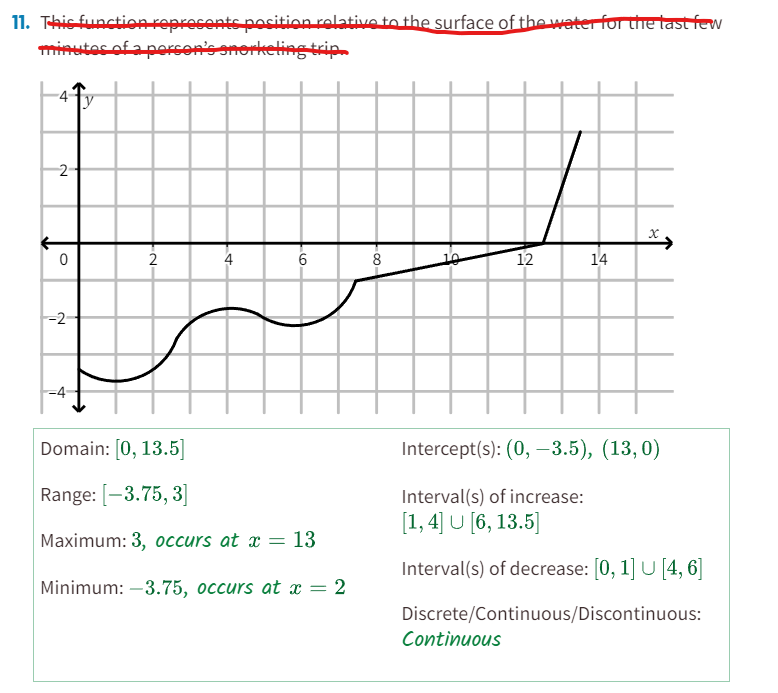



- Domain :
- Range : 
- Maximum : 
- Minimum :
- Intercepts :
- Interval(s) of increase: 
- Interval(s) of decrease: 
- Interval(s) of constant: 
- Discrete / Continuous / Discountinuous : 

In [ ]:
def PWChars(pieces=randint(3,5), cont=True, expr='latex'):
    endPts, pairs = [0], []

    for jj in range(pieces):
        if jj == 0:
            start = randint(-8,8)
        else:
            if cont or randint(0,1):
                start = pairs[-1][0].subs(x,endPts[jj])
            else:
                start = randint(-8,8)
        
        kind = randint(1,2)         # No exponential pieces yet
        if kind == 1:               # Linear
            slope = Rational(getInt(-6,6),randint(1,3))
            func = LinFunc(slope, [endPts[jj],start])
            step = randint(3,6) if slope.q==1 else randint(1,3)*slope.q
        elif kind == 2:             # Quadratic
            step = randint(2,4)
            func = QuadFunc.from2Pts(1, [endPts[jj],start], [endPts[jj]+step,start+randint(-4,4)])
        else:                       # Exponential           TODO: Fix exponential pieces
            step = randint(2,4)
            func = ExpFunc(Rational(1,randint(2,5)), [endPts[jj],start])
        
        endPts.append(endPts[jj] + step)
        interval = f'{endPts[jj]},{endPts[jj+1]}'
        if jj == 0:
            interval = ('(' + interval) if randint(0,1) else ('[' + interval)
        else:                       # Make sure intervals don't overlap
            if cont:
                interval = '[' + interval
            else:
                interval = ('(' + interval) if (pairs[-1][1][-1]==']' or randint(0,1)) else ('[' + interval)
        interval += ')' if (cont or randint(0,1)) else ']'

        expression = func.expr if type(func)!=ExpFunc else func.subs(func.variable-endPts[jj])*func.base**endPts[jj]
        pairs.append([expression, interval])
    
    func = PWFunc(*pairs)

    problem = graphPW(func, contDot=True)
    answer = func.printFeats()

    return problem, answer

for jj in range(5):
    problem, answer = PWChars(randint(3,5), cont=False)
    print(problem)
    print(answer)

\begin{tikzpicture}\begin{axis}[mmt axis style,xmin=-1,xmax=21,xtick={-5,0,...,26},ymin=-11,ymax=11,ytick={-15,-10,...,16},]\addplot[black,solid,thick,domain=0:4,samples=100] {x^2 - 19*x/4 - 2};\fill[draw=black,fill=black] (axis cs: 0,-2) circle(2pt);\addplot[black,solid,thick,domain=4:7,samples=100] {x - 9};\fill[draw=black,fill=black] (axis cs: 4,-5) circle(2pt);\addplot[black,solid,thick,domain=7:16,samples=100] {x/3 - 1/3};\fill[draw=black,fill=white] (axis cs: 7,2) circle(2pt);\fill[draw=black,fill=white] (axis cs: 7,-2) circle(2pt);\fill[draw=black,fill=black] (axis cs: 16,5) circle(2pt);\end{axis}\end{tikzpicture}
Domain: $\left[0, 7\right) \cup \left(7, 16\right]$ \newline Range: $\left[-7.64, -2.0\right] \cup \left(2.0, 5.0\right]$ \newline $y$-intercept: $(0, -2)$ \newline $x$-intercept(s): None \newline Minimum: $-7.64$, occurs at $x=2.38$ \newline Maximum: $5$, occurs at $x=16$ \newline Increasing: $\left(2.38, 7.0\right) \cup \left(7.0, 16.0\right]$\newline Decreasing: $\l

## section 2 : recursive

### instruction :  For each of the following functions, find the desired features.

#### option 1: arith 
#### option 2: geo



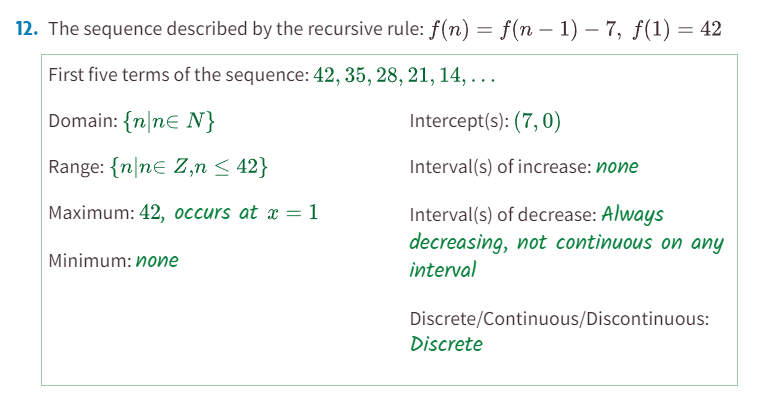

- Domain :
- Range : 
- Maximum : 
- Minimum :
- Intercepts :
- Interval(s) of increase: 
- Interval(s) of decrease: 
- Interval(s) of constant: 
- Discrete / Continuous / Discountinuous : 

In [ ]:
def SeqFeats(kind='lin'):                   # TODO: Answer
    if kind == 'lin':
        seq = ArithSeq(randint(-7,7), [1,randint(-50,50)])
    elif kind == 'exp':
        base = randint(2,5) if randint(0,1) else Rational(1,randint(2,5))
        seq = GeoSeq(base, [1,getInt(-7,7)])

    problem = seq.getRecursive() + r' \newline '
    problem += r'First five terms of the sequence: \newline '
    problem += r'Domain: \newline Range: \newline Maximum: \newline Minimum \newline '
    problem += r'Intercept(s): \newline Interval(s) of increase: \newline Interval(s) of decrease: \newline '
    problem += r'Discrete/Continuous/Discontinuous:'

    answer = fr'First five terms of the sequence: ${seq.getSeqStr(range(1,6))}$ \newline '
    answer += fr'Domain: \newline Range: \newline '
    answer += fr'Maximum: \newline Minimum \newline '
    answer += fr'Intercept(s): \newline '
    answer += fr'Interval(s) of increase: \newline '
    answer += fr'Interval(s) of decrease: \newline '
    answer += fr'Discrete/Continuous/Discontinuous: Discrete'

    return problem, answer

for jj in range(5):
    problem, answer = SeqFeats()
    print(problem)
    print(answer)

## AGS1.3.3.3 - Finding Explicit And Recursive Equations

### instruction : Find both the explicit and recursive equations for the tables.

#### option 1 : easy
#### option 2 : medium
#### option 3 : hard

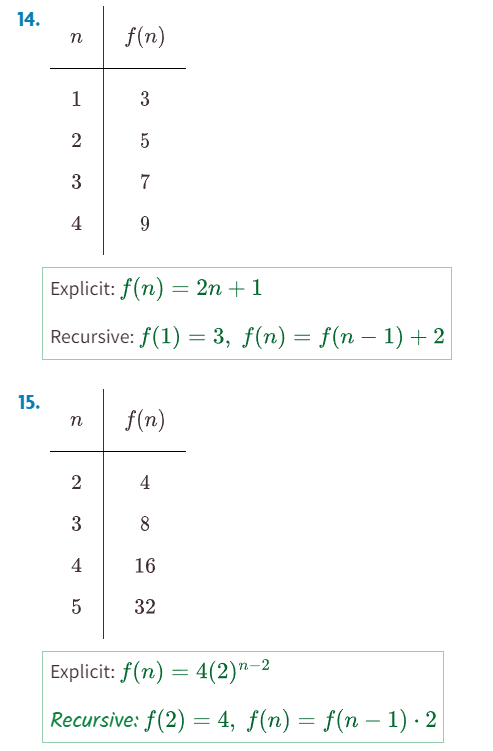

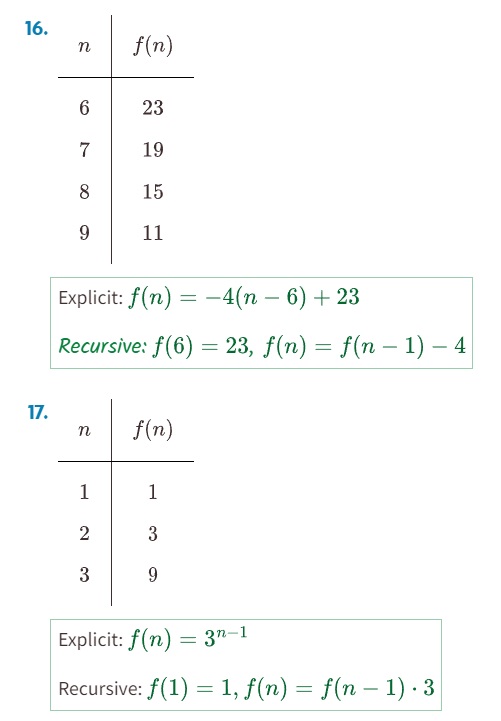

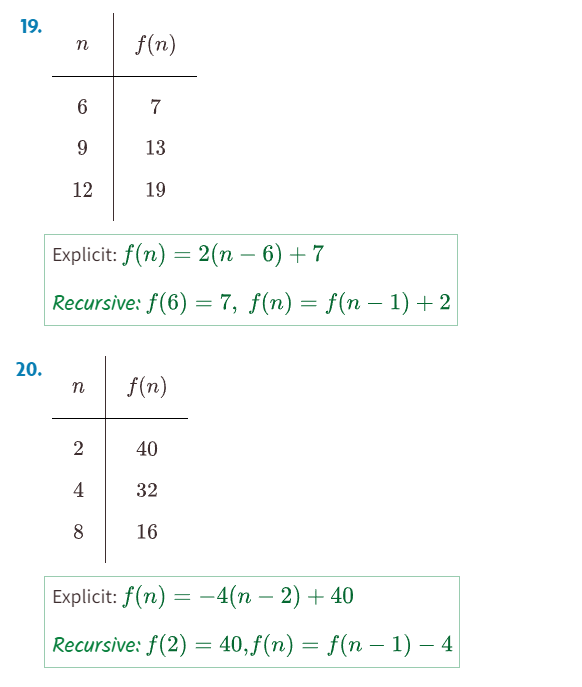

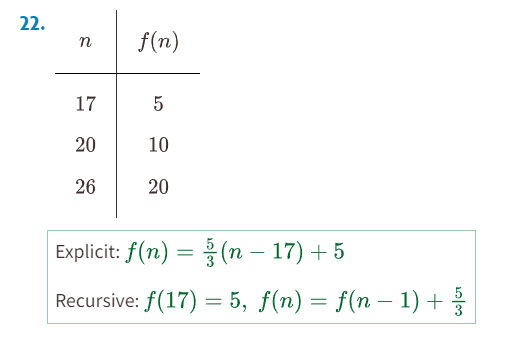

#### easy: start from 1, constant increment

problem : display table

| n | f(n) |
| :---: | :---: |
| 1 | 3 |
| 2 | 5 |
| 3 | 7 |
| 4 | 9 |

#### medium: Start from 2~6, constant increment

| n | f(n) |
| :---: | :---: |
| 6 | 23 |
| 7 | 19 |
| 8 | 15 |
| 9 | 11 |

#### Hard : Start Random spots and jump 
keep geometric common ratio low
[1/2 , 1/3 , 1/4 , 2,3,4]

| n | f(n) |
| :---: | :---: |
| 6 | 7 |
| 9 | 13 |
| 12 | 19 |

or

| n | f(n) |
| :---: | :---: |
| 17 | 5 |
| 20 | 10 |
| 26 | 20 |



In [ ]:
def Finding_Explicit_And_Recursive_Equations_3_3_3(expr='latex',case=1,lin_or_geo='lin'):
    '''
    expr = latex or sympy
    case = 1 easy 2 medium 3 hard
    lin_or_geo = force to generate lin or geo 
    '''
    if lin_or_geo == 'geo' or random.randint(0,1) == 1:
        seq = GeoSeq(getInt(-4,4), [1,getInt(-5,5)])
    else:
        seq = ArithSeq(getInt(-10,10), [1,getInt(-10,10)])
    
    if case == 1:
        start = 1
        problem = seq.getTable(range(1,4), vals=[1,1,1,1], vertical=True, labels=[fr'$n$',fr'$f(n)$'])
    elif case == 2:
        start = random.randint(2,6)
        finish = start + 4
        problem = seq.getTable(range(start,finish), vals=[1,1,1,1], vertical=True, labels=[fr'$n$',fr'$f(n)$'])
    else:
        start = random.randint(4,12)
        if lin_or_geo == 'geo' or random.randint(0,1) == 1:
            seq = GeoSeq(getInt(-3,3), [start,getInt(-3,3)])
        terms = seq.getTerms(12,start)
        keys = sorted(random.sample(list(terms),4))
        vals = [terms[i] for i in keys]
        problem = seq.getTable(keys, vals, vertical=True, labels=[fr'$n$',fr'$f(n)$'])
      
    if expr == 'latex':
        answer='Explicit ' + signify(seq.getExplicit(start)) + r'\newline'+' Recursive '+signify(seq.getRecursive(start))
    else:
        answer='Explicit ' + signify(seq.getExplicit(start)) + r'\newline'+' Recursive '+signify(seq.getRecursive(start))
  
    return problem, answer
'''
for i in range(1):
  prob , ans = Finding_Explicit_And_Recursive_Equations_3_3_3('latex',1,'lin')
  prob , ans = Finding_Explicit_And_Recursive_Equations_3_3_3('latex',2,'lin')
  prob , ans = Finding_Explicit_And_Recursive_Equations_3_3_3('latex',3,'lin')
'''
for i in range(3):
  prob , ans = Finding_Explicit_And_Recursive_Equations_3_3_3('latex',3,'geo')
  print(prob)
  print(ans)

{\renewcommand{\arraystretch}{1.5}	\begin{center}
		\begin{tabular}{|c|c|}
			\hline
			$n$ & $f(n)$ \\
			\hline
			$2$ & $-2$ \\
			\hline
			$7$ & $-2$ \\
			\hline
			$8$ & $-2$ \\
			\hline
			$9$ & $-2$ \\
			\hline
		\end{tabular}
	\end{center}}
Explicit $f(n) = -21$\newline Recursive $f(n) = 1\cdot f(n-1),\quad f(7) = -2$
{\renewcommand{\arraystretch}{1.5}	\begin{center}
		\begin{tabular}{|c|c|}
			\hline
			$n$ & $f(n)$ \\
			\hline
			$0$ & $- \frac{1}{32}$ \\
			\hline
			$3$ & $\frac{1}{4}$ \\
			\hline
			$6$ & $-2$ \\
			\hline
			$11$ & $64$ \\
			\hline
		\end{tabular}
	\end{center}}
Explicit $f(n) = \left(-2\right)^{n - 5}$\newline Recursive $f(n) = -2\cdot f(n-1),\quad f(5) = 1$
{\renewcommand{\arraystretch}{1.5}	\begin{center}
		\begin{tabular}{|c|c|}
			\hline
			$n$ & $f(n)$ \\
			\hline
			$1$ & $0.0$ \\
			\hline
			$3$ & $\frac{1}{256}$ \\
			\hline
			$4$ & $\frac{1}{128}$ \\
			\hline
			$11$ & $1$ \\
			\hline
		\end{tabular}
	\end{center}}
Explicit $f(n) = 2

## AGS1.3.4.1 - Find The Indicated Values
### Instruction : Find the indicated values & Find equation or graph the explicit function

#### option 1: equation


Problem : Graph the explicit function $f(x) = linear /  geometric $ and find the indicated values. 



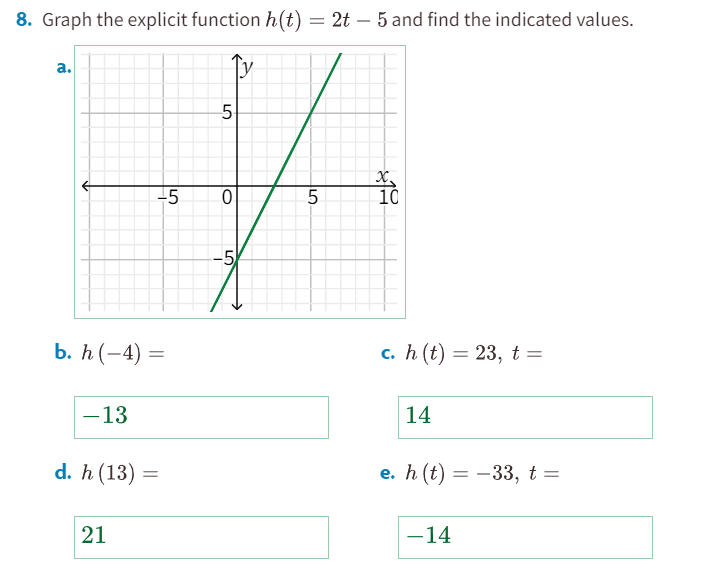

In [ ]:
#---AGS1.3.4.1-------generator
import sympy
import random
def Find_The_Indicated_Values_3_4_1(expr='sympy',option=1):
    '''
    expr = latex , sympy
    option = 1 : linear
             2  : geometric
    returns -------------------------------------------
    problem = tikz code for the graph
    expr = sympy expression
    xlist = list of x coordinate for each problem sets
    ylist = list of x coordinate for each problem sets
    '''

    #random_boolean = bool(random.getrandbits(1))
    x = sympy.Symbol('x')
    if option == 1:
      case = random.randint(1,3)
      if case == 1:
        eq = linearEQgenerator(False,False,False,False,-10,10,-10,10,1,6)
      elif case == 2:
        eq = linearEQgenerator(False,False,True,False,-10,10,-10,10,1,6)
      elif case == 3:
        eq = linearEQgenerator(False,False,True,True,-10,10,-10,10,1,6)
      answergraph = startGraph()+drawLinear(eq,-8,8)+endGraph()
      eq = sympy.sympify(eq,rational = True)
      xlist = random.sample(range(-30, 30), 4)
    else:
      ratio = random.choice([Rational(1,2),Rational(1,3),2,3,4])
      yint = random.choice([-4,-3,-2,2,3,4])
      eq = f'{yint} * ({ratio}) ** x'
      answergraph = startGraph()+drawCurve(eq,-8,8)+endGraph()
      eq = sympy.sympify(eq,rational = True)
      xlist = random.sample(range(-5, 5),4)

    ylist=[]
    for i in range(len(xlist)):
      ylist.append(eq.subs(x,xlist[i]))

    if option == 1:
      question = r'Graph the explicit function $f(x)= '+sympy.latex(sympy.sympify(eq))+r'$ and find the indicated values. \\ a) '
      answer ='a) '+ answergraph +r'\\'
      question += emptyGraph(-10,10,-10,10)
      question += r'\\ '
      option = ['b','c','d','e']
      for i in range(4):
        if i%2 != 0:
          question += fr'{option[i]}) $f({sympy.latex(xlist[i])})= $ \\'
          answer += fr'{option[i]}) $f({sympy.latex(xlist[i])})= {sympy.latex(ylist[i])}$ '
        else:
          question += fr'{option[i]}) $f(x)={sympy.latex(ylist[i])}, x = $ \\'
          answer += fr'{option[i]}) $f({sympy.latex(xlist[i])})= {sympy.latex(ylist[i])}$ '
    else: # option 2
      answer = 'a) '+ answergraph+r'\\'
      question = r'Graph the explicit function $f(x)= '+sympy.latex(eq)+r'$ and find the indicated values. \\ a) '
      question += emptyGraph(-10,10,-10,10)
      question += r'\\ '
      option = ['b','c','d','e']
      for i in range(4):
        if i%2 != 0:
          question += fr'{option[i]}) $f({sympy.latex(xlist[i])})= $ \\'
          answer += fr'{option[i]}) $f({sympy.latex(xlist[i])})= {sympy.latex(ylist[i])}$ '
        else:
          question += fr'{option[i]}) $f(x)={sympy.latex(ylist[i])}, x = $ \\'
          answer += fr'{option[i]}) $f({sympy.latex(xlist[i])})= {sympy.latex(ylist[i])}$ '
    
    answer += r'\\'
    return question, answer

In [ ]:
#---AGS1.3.4.1-------Caller
for i in range(10):
  print('Arith-------------------------------')
  question , answer = Find_The_Indicated_Values_3_4_1(expr='sympy',option=1)
  print('question: ',question)
  print(' ')
  print('answer: ',answer)
  print(' ')


Arith-------------------------------
question:  Graph the explicit function $f(x)= 5 x + 1$ and find the indicated values. \\ a) \begin{tikzpicture}\begin{axis}[mmt axis style,xmin=-10,xmax=10,xtick={-10,-5,...,15},ymin=-10,ymax=10,ytick={-10,-5,...,15},]\end{axis}\end{tikzpicture}\\ b) $f(x)=111, x = $ \\c) $f(29)= $ \\d) $f(x)=-19, x = $ \\e) $f(-24)= $ \\
 
answer:  a) \begin{tikzpicture}\begin{axis}[mmt axis style,xmin=-10,xmax=10,xtick={-10,-5,...,15},ymin=-10,ymax=10,ytick={-10,-5,...,15},]\addplot[domain=-8:8, color=black,name path=f]{5*x+1};\end{axis}\end{tikzpicture}\\b) $f(22)= 111$ c) $f(29)= 146$ d) $f(-4)= -19$ e) $f(-24)= -119$ \\
 
Arith-------------------------------
question:  Graph the explicit function $f(x)= \frac{2 x}{3} - 3$ and find the indicated values. \\ a) \begin{tikzpicture}\begin{axis}[mmt axis style,xmin=-10,xmax=10,xtick={-10,-5,...,15},ymin=-10,ymax=10,ytick={-10,-5,...,15},]\end{axis}\end{tikzpicture}\\ b) $f(x)=\frac{37}{3}, x = $ \\c) $f(-24)= $ \\d) 

#### option 2: graph

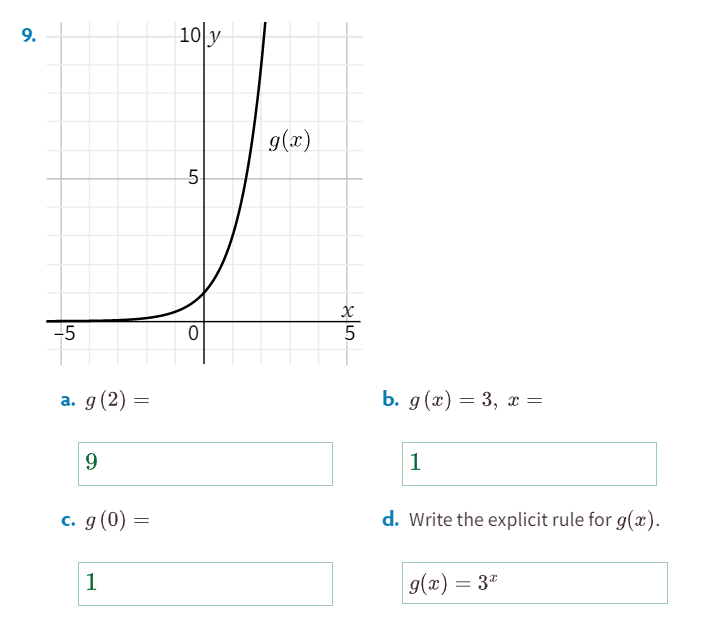

In [ ]:
for i in range(4):
  print('GEO-------------------------------')
  question , answer = Find_The_Indicated_Values_3_4_1(expr='sympy',option=1)
  print('question ------')
  print(question)
  print(answer)

GEO-------------------------------
question ------
Graph the explicit function $f(x)= $4 - \frac{x}{6}$ and find the indicated values. \\ a) \begin{tikzpicture}\begin{axis}[mmt axis style,xmin=-10,xmax=10,xtick={-10,-5,...,15},ymin=-10,ymax=10,ytick={-10,-5,...,15},]\end{axis}\end{tikzpicture}\\ b) $f(x)=9, x = $ \\c) $f(29)= $ \\d) $f(x)=\frac{7}{2}, x = $ \\e) $f(-12)= $ \\
a) \begin{tikzpicture}\begin{axis}[mmt axis style,xmin=-10,xmax=10,xtick={-10,-5,...,15},ymin=-10,ymax=10,ytick={-10,-5,...,15},]\addplot[domain=-8:8, color=black,name path=f]{-1/6*x+4}\end{axis}\end{tikzpicture}\\b) $f(-30)= 9$ c) $f(29)= - \frac{5}{6}$ d) $f(3)= \frac{7}{2}$ e) $f(-12)= 6$ \\
GEO-------------------------------
question ------
Graph the explicit function $f(x)= $- \frac{9 x}{4} - 1$ and find the indicated values. \\ a) \begin{tikzpicture}\begin{axis}[mmt axis style,xmin=-10,xmax=10,xtick={-10,-5,...,15},ymin=-10,ymax=10,ytick={-10,-5,...,15},]\end{axis}\end{tikzpicture}\\ b) $f(x)=-10, x = $ \\c)

## AGS1.3.4.2 - Graph The New Equation

### Instruction : Two functions are graphed. Graph a new function on the same grid by adding the two given functions.

#### option 1: linear + linear


#### option 2: linear + geometric


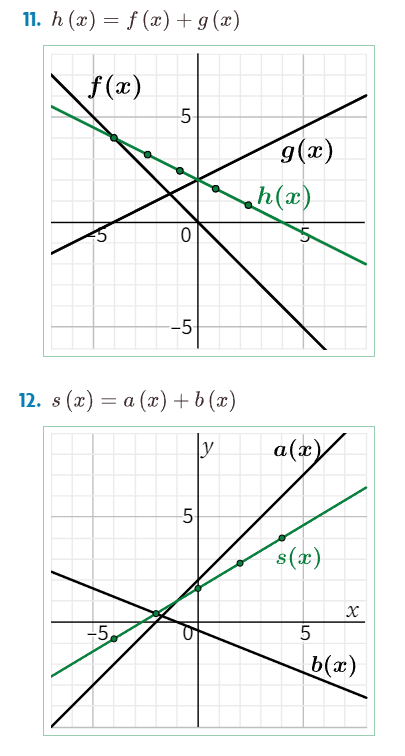

In [ ]:
import sympy
def Find_The_Indicated_Values_3_4_2(expr='sympy',option=1):
    '''
    expr = latex , sympy
    option = 1 : linear + linear
             2  : geometric + linear
    returns -------------------------------------------
    problem = tikz code for the graph
    expr = sympy expression
    xlist = list of x coordinate for each problem sets
    ylist = list of x coordinate for each problem sets
    '''

    #random_boolean = bool(random.getrandbits(1))
    x = sympy.Symbol('x')
    funcVar = ['a','b','c','d','e','f','g','q','z','k','l','m','m','o','p']
    funcLabel = random.sample(funcVar,3)
    xmin,xmax = -10 , 10

    if option == 1:
      # generate equations & solutions
      eq1lhs,eq1rhs,eq2lhs,eq2rhs,sol = Systems_of_Equation('sympy','point_slope',3,3,3)
      eq3rhs = sympy.sympify(eq1rhs + eq2rhs,rational = True)
      #generate solution_graph
      problem_graph = startGraph() + drawLinear(eq1rhs,xmin,xmax,'black',funcLabel[0])+ drawLinear(eq2rhs,xmin,xmax,'black',funcLabel[1])+ endGraph()
      answer_graph = startGraph() + drawPt(sol) + drawLinear(eq1rhs,xmin,xmax,'black',funcLabel[0])+ drawLinear(eq2rhs,xmin,xmax,'black',funcLabel[1])+drawLinear(eq3rhs,xmin,xmax,'black',funcLabel[2])

    else:
      ratio = random.choice([Rational(1,2),Rational(1,3),2,3])
      yint = random.choice([-4,-3,-2,2,3,4])
      eq1rhs = f'{yint} * ({ratio}) ** x'
      problem_graph = startGraph()+drawCurve(eq1rhs,-10,10,funcLabel[0])
      
      #generate empty grids
      case = random.randint(1,3)
      if case == 1:
        eq2rhs = linearEQgenerator(False,False,False,False,-10,10,-5,5,1,6)
      elif case == 2:
        eq2rhs = linearEQgenerator(False,False,True,False,-10,10,-5,5,1,6)
      elif case == 3:
        eq2rhs = linearEQgenerator(False,False,True,True,-10,10,-5,5,1,6)
      
      problem_graph += drawLinear(eq2rhs,-10,10,'black',funcLabel[1])
      #sol = sympy.linsolve([Eq(eq1rhs,0),Eq(eq2rhs)])
      eq3rhs = sympy.sympify(eq1rhs+eq2rhs,rational=True)
      #print('sol-----!@#!@#!@#',sol)
      answer_graph = problem_graph + drawCurve(eq3rhs,-10,10,funcLabel[2])

    xlistmax = [i for i in range(-10,11)]
    xlist = [-4,-2,-1,1,2,4]
    ylist = []
    
    for i in range(len(xlist)):
      f1 = lambdify(x,eq1rhs)
      f2 = lambdify(x,eq2rhs)
      ylist.append([f1(i),f2(i)])
      answer_graph += drawPt([i,f1(i)])
      answer_graph += drawPt([i,f2(i)])
        
    answer_graph += r'\addplot[color=blue,mark=square,]coordinates {'
    for i in range(len(xlistmax)):
      f1 = lambdify(x,eq1rhs)
      f2 = lambdify(x,eq2rhs)
      answer_graph += f'({f1(i)},{f2(i)})'
      answer_graph += drawPt([i,f2(i)])
    
    answer_graph =answer_graph+'};'+endGraph()

    header = fr'${funcLabel[2]}(x)= {funcLabel[0]}(x) + {funcLabel[1]}(x)$'
    '''
    header = problem display
    problem graph = TIKZ RETURN graph
    answer graph = TIKZ return,  f(x) + g(x) = k(x)
    '''
    print('eq1',eq1rhs,'eq2',eq2rhs,'eq3',eq3rhs,'xlist',xlist,'ylist',ylist)
    return header , problem_graph+endGraph() , answer_graph

In [ ]:
for i in range(1):
  header,prob,ans = Find_The_Indicated_Values_3_4_2(expr='sympy',option=1)
  print(header)
  print(prob)
  print(ans)
for i in range(1):
  header,prob,ans = Find_The_Indicated_Values_3_4_2(expr='sympy',option=2)
  print(header)
  print(prob)
  print(ans)

eq1 -x/2 - 7/2 eq2 -x - 4 eq3 -3*x/2 - 15/2 xlist [-4, -2, -1, 1, 2, 4] ylist [[-3.5, -4], [-4.0, -5], [-4.5, -6], [-5.0, -7], [-5.5, -8], [-6.0, -9]]
$m(x)= g(x) + k(x)$
\begin{tikzpicture}\begin{axis}[mmt axis style,xmin=-10,xmax=10,xtick={-10,-5,...,15},ymin=-10,ymax=10,ytick={-10,-5,...,15},]\addplot[domain=-10:10, color=black,name path=g]{-x/2 - 7/2}\addplot[domain=-10:10, color=black,name path=k]{-x - 4}\end{axis}\end{tikzpicture}\end{axis}\end{tikzpicture}
\begin{tikzpicture}\begin{axis}[mmt axis style,xmin=-10,xmax=10,xtick={-10,-5,...,15},ymin=-10,ymax=10,ytick={-10,-5,...,15},]\fill[draw=black,fill=black] (axis cs: -1,-3) circle(2pt);\addplot[domain=-10:10, color=black,name path=g]{-x/2 - 7/2}\addplot[domain=-10:10, color=black,name path=k]{-x - 4}\addplot[domain=-10:10, color=black,name path=m]{-3*x/2 - 15/2}\fill[draw=black,fill=black] (axis cs: 0,-3.5) circle(2pt);\fill[draw=black,fill=black] (axis cs: 0,-4) circle(2pt);\fill[draw=black,fill=black] (axis cs: 1,-4.0) circle

## AGS1.3.4.3- Compare Two Functions 
### Instruction : Use the graph to answer the following questions.

#### option 1: linear vs linear
#### option 2: linear vs exponential

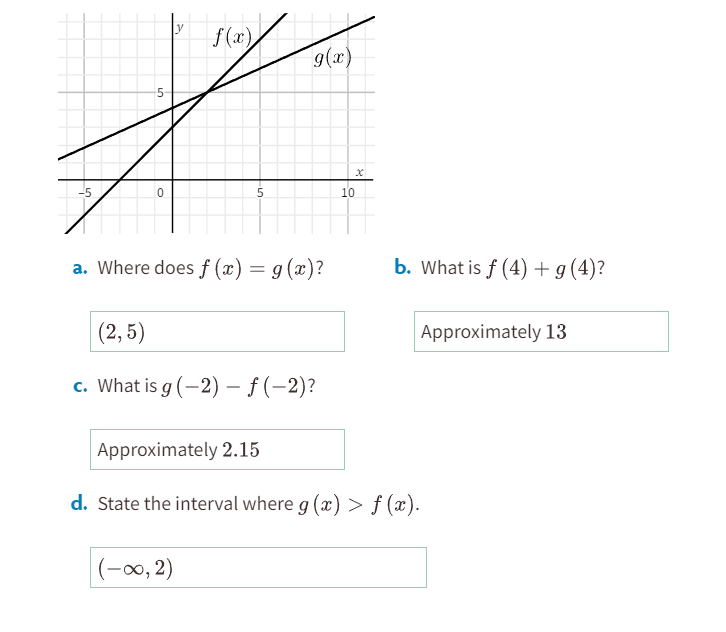

Problem 

a. Where does $f(x) = g(x)$

b. What is $f(intA) + g(intA)$

c. What is $f(intB) - g(intB)$

d. State the interval where $ g(x) > f(x) $

e. State the interval where $ f(x) > g(x) $

In [ ]:
import sympy , random
import numpy as np
import scipy.optimize as opt

def Compare_Two_Functions_3_4_3(expr='sympy',option=1):
    '''
    expr = latex , sympy
    option = 1 : linear + linear
             2  : geometric + linear
    returns -------------------------------------------
    problem = tikz code for the graph
    expr = sympy expression
    xlist = list of x coordinate for each problem sets
    ylist = list of x coordinate for each problem sets
    '''

    #random_boolean = bool(random.getrandbits(1))
    x = Symbol('x')
    funcVar = ['a','b','c','d','e','f','g','q','z','k','l','m','m','o','p']
    funcLabel = sample(funcVar,2)
    xmin,xmax = -10 , 10
    xlist = [-3,-2,-1,0,1,2,3]


    if option == 1:
      xlistmax = [i for i in range(xmin,xmax)]
      # generate equations & solutions
      eq1lhs,eq1rhs,eq2lhs,eq2rhs,sol = Systems_of_Equation('sympy','point_slope',3,3,3)
      #generate solution_graph
      problem_graph = r'\newline'+startGraph() + drawLinear(eq1rhs,xmin,xmax,'black',funcLabel[0])+ drawLinear(eq2rhs,xmin,xmax,'black',funcLabel[1])+ endGraph()
      eq1rhs = sympify(eq1rhs,rational = True)
      eq2rhs = sympify(eq2rhs,rational = True)
      
      question = fr'\newline a) Where does ${funcLabel[0]}(x)= {funcLabel[1]}(x) $ ? \\'
      answer_text = question + f'({sol[0],sol[1]})'

      y1list = []
      y2list = []
      f1 = lambdify(x,eq1rhs)
      f2 = lambdify(x,eq2rhs)
      b = sample(xlist,2)
      for i in range(len(xlistmax)):
        y1list.append(f1(i))
        y2list.append(f2(i))

      '''
      print(b)
      print('xlist',xlist)
      print('y1ist',y1list)
      print('y2ist',y2list)
'''
      question_b = fr'b) What is ${funcLabel[0]}({b[0]}) + {funcLabel[1]}({b[0]}) $ ? \\'
      question += question_b 
      answer_text = answer_text + question_b + fr'Approximately {y1list[b[0]] + y2list[b[0]] }'
      
      question += fr'c) What is ${funcLabel[1]}({b[1]}) - {funcLabel[0]}({b[1]}) $ ? \\'
      answer_text += fr'Approximately { y1list[b[1]] - y2list[b[1]]}'
      
      question += 'd) '+fr'State the interval where ${funcLabel[0]}(x) > {funcLabel[1]}(x) $ \\' 
      answer_text += r'$'+ sympy.latex(sympy.solveset(eq1rhs > eq2rhs, x, S.Reals)) + r'$'

      question += 'e) '+fr'State the interval where ${funcLabel[0]}(x) \leq {funcLabel[1]}(x) $ \\' 
      answer_text += r'$'+ sympy.latex(sympy.solveset(eq1rhs <= eq2rhs, x, S.Reals)) + r'$'

    else:
      xlistmax = [i for i in np.arange(xmin,xmax,0.1)]
      xlist = [-3,-2,-1,0,1,2,3]
      #generate expo func
      ratio = choice([Rational(1,2),Rational(1,3),2,3])
      eq1rhs=ExpFunc(ratio,[getInt(),getInt()])
      problem_graph = r'\newline'+startGraph()+drawCurve(eq1rhs.expr,-10,10,funcLabel[0])
      #generate lin func reduce overlaping cases or generate more logical "fitting" type of problems
      if ratio < 0:
        slope = getInt(-5,-1)
      else:
        slope = getInt(1,5)
      yint = getInt()
      eq2rhs = LinFunc(slope,yint)
      problem_graph += drawLinear(eq2rhs.expr,-10,10,'black',funcLabel[1]) + endGraph()
      eq1rhs = sympify(eq1rhs.expr,rational = True)
      eq2rhs = sympify(eq2rhs.expr,rational = True)
      '''
      print('x,y',x,y)
      print(eq1rhs,eq2rhs)

      '''
      print(xlistmax)
      #storage
      y1list = []
      y2list = []
      result = []
      intersect = []
      # pick 2 random x values for the prob
      b = random.sample(xlist,2)
      # start comparision instead of using inequality needs to be updated later
      f1 = lambdify(x,eq1rhs)
      f2 = lambdify(x,eq2rhs)
      for i in xlistmax:
        temp1 = round(f1(i),1)
        temp2 = round(f2(i),1)
        y1list.append(temp1)
        y2list.append(temp2)
        result.append(1 if temp1 > temp2 else 0)
#        print("temp1:", temp1," temp2: ",temp2)
      
      for i in range(len(result) -1):
        if result[i] != result[i+1]:
          intersect.append(i)
      
      print('xlist',xlist)
      print('y1list',y1list)
      print('y2list',y2list)
      print(result)
      print(intersect)
      
      '''
      # if first > second all the way
      if len(set(result)) == 1:
        answer_d = r"(-\infty , \infty)"
        answer_e = "None"
      elif len(set(result)) == 0:
        answer_d = "None"
        answer_e = r"(-\infty , \infty)"
      # figuring out interval notation
      else:
        for temp in len(intersect):
          if intersect(temp) >
      '''   




      question_a= fr'\newline a) Where does ${funcLabel[0]}(x)= {funcLabel[1]}(x) $ ? \\'
      answer_text = question_a + fr'{x},{y} \newline'

      question_b = fr'b) What is ${funcLabel[0]}({b[0]}) + {funcLabel[1]}({b[0]}) $ ? \\'
      answer_text = answer_text + question_b + fr'Approximately {y1list[b[0]] + y2list[b[0]] } \\'
      
      question_c = fr'c) What is ${funcLabel[1]}({b[1]}) - {funcLabel[0]}({b[1]}) $ ? \\'
      answer_text = answer_text + question_c + fr'Approximately { y1list[b[1]] - y2list[b[1]]} \\'

      question = question_a+question_b+question_c
      '''
      question_d= fr'd) State the interval where ${funcLabel[0]}(x) > {funcLabel[1]}(x) $ \\' 
      answer_text = answer_text + question_d + r'$'+ sympy.latex(sympy.solveset(eq1rhs > eq2rhs, x, S.Reals)) + r'$'

      question_e = fr'e) State the interval where ${funcLabel[0]}(x) \leq {funcLabel[1]}(x) $ \\' 
      answer_text = answer_text + question_e+ r'$'+ sympy.latex(sympy.solveset(eq1rhs <= eq2rhs, x, S.Reals)) + r'$'
      '''

    '''
    problem graph = TIKZ problem graph
    answer graph = TIKZ answer graph,  f(x) + g(x)
    '''
  #  print('eq1',eq1rhs,'eq2',eq2rhs,'xlist',xlist,'y1list',y1list,'y2list',y2list)
    return problem_graph, question , answer_text

In [ ]:
for i in range(1):
  problem_graph , question , answer_text = Compare_Two_Functions_3_4_3('sympy',2)
  print(problem_graph)
  print(question)
  print(answer_text)

[-10.0, -9.9, -9.8, -9.700000000000001, -9.600000000000001, -9.500000000000002, -9.400000000000002, -9.300000000000002, -9.200000000000003, -9.100000000000003, -9.000000000000004, -8.900000000000004, -8.800000000000004, -8.700000000000005, -8.600000000000005, -8.500000000000005, -8.400000000000006, -8.300000000000006, -8.200000000000006, -8.100000000000007, -8.000000000000007, -7.9000000000000075, -7.800000000000008, -7.700000000000008, -7.6000000000000085, -7.500000000000009, -7.400000000000009, -7.30000000000001, -7.20000000000001, -7.10000000000001, -7.000000000000011, -6.900000000000011, -6.800000000000011, -6.700000000000012, -6.600000000000012, -6.500000000000012, -6.400000000000013, -6.300000000000013, -6.2000000000000135, -6.100000000000014, -6.000000000000014, -5.900000000000015, -5.800000000000015, -5.700000000000015, -5.600000000000016, -5.500000000000016, -5.400000000000016, -5.300000000000017, -5.200000000000017, -5.100000000000017, -5.000000000000018, -4.900000000000018, 

## AGS1.3.4.4 - Domain & Range / Increasing or Decreasing
### Instruction : For each graph, identify the domain, range, and whether or not the function is increasing or decreasing.

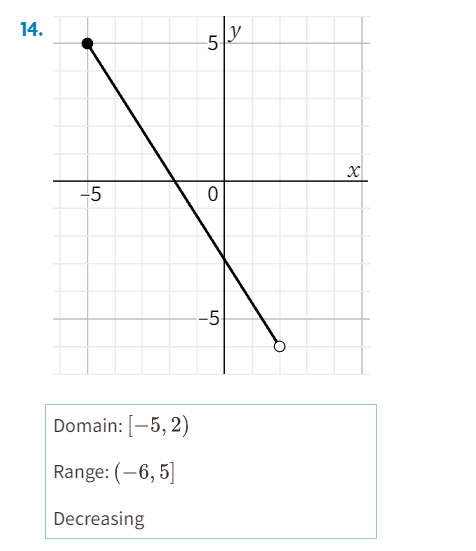

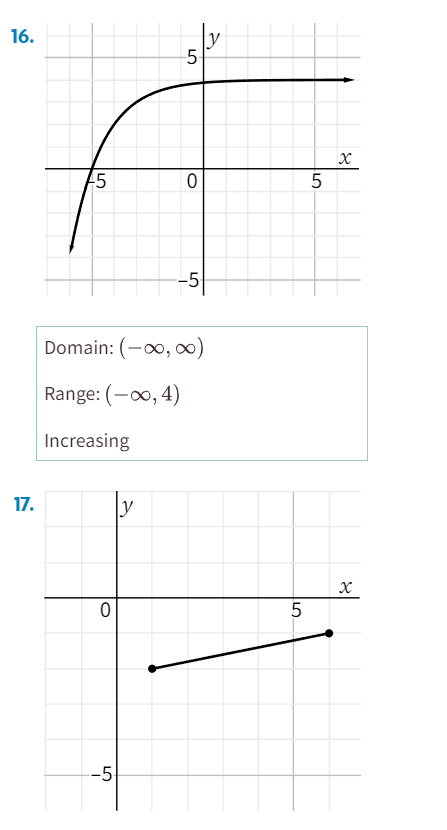

In [ ]:
def graphChars_3_4_4(expr='latex'):
    case = randint(1,2)

    start = randint(-8,2) if randint(0,9) else -oo
    if randint(0,9):
        end = (start+randint(4,10)) if start!=-oo else randint(4,10)
    else:
        end = choice([start+randint(4,10), oo]) if start!=-oo else choice([randint(4,10), oo])
    domain = choice(['(','[']) + f'{start},{end}' + choice([')',']'])
    
    if case == 1:           # Linear
        func = LinFunc(getInt(-3,3),randint(-3,3))
    elif case == 2:         # Exponential
        base = randint(2,4) if randint(0,1) else Rational(1,randint(2,4))
        func = ExpFunc(base, [randint(-3,3),randint(-3,3)], randint(-3,3))

    func = PWFunc([func.expr,domain])
    problem = graphPW(func)

    answer = func.printFeats(['domain','range'])
    feats = func.getFeats(['change'])
    answer += 'Decreasing' if feats['dec']!=EmptySet else 'Increasing'

    return problem, answer

for jj in range(5):
    problem, answer = graphChars_3_4_4()
    print(problem)
    print(answer)

\begin{tikzpicture}\begin{axis}[mmt axis style,xmin=-6,xmax=6,xtick={-10,-5,...,11},ymin=-26,ymax=6,ytick={-30,-25,...,11},]\addplot[black,solid,thick,domain=-1:4,samples=100] {2 - 3^x/3};\fill[draw=black,fill=white] (axis cs: -1,17/9) circle(2pt);\fill[draw=black,fill=black] (axis cs: 4,-25) circle(2pt);\end{axis}\end{tikzpicture}
Domain: $\left(-1, 4\right]$ \newline Range: $\left[-25.0, 1.89\right)$ \newline Decreasing
\begin{tikzpicture}\begin{axis}[mmt axis style,xmin=-6,xmax=6,xtick={-10,-5,...,11},ymin=-131,ymax=1,ytick={-135,-130,...,6},]\addplot[black,solid,thick,domain=-5:0,samples=100] {2 - 4*2^(-x)};\fill[draw=black,fill=black] (axis cs: -5,-126) circle(2pt);\fill[draw=black,fill=white] (axis cs: 0,-2) circle(2pt);\end{axis}\end{tikzpicture}
Domain: $\left[-5, 0\right)$ \newline Range: $\left[-126, -2\right)$ \newline Increasing
\begin{tikzpicture}\begin{axis}[mmt axis style,xmin=-11,xmax=6,xtick={-15,-10,...,11},ymin=-16,ymax=11,ytick={-20,-15,...,16},]\addplot[black,solid